<a href="https://colab.research.google.com/github/jwjung1994/DL-examples/blob/main/gan_example_using_mnist_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# 생성자
def generator():
    
    g = Sequential()
    g.add(Dense(128*7*7, input_dim = 100, activation = LeakyReLU(0.2)))
    g.add(BatchNormalization())
    g.add(Reshape((7, 7, 128)))
    g.add(UpSampling2D())
    g.add(Conv2D(64, kernel_size = 5, padding = 'same'))
    g.add(BatchNormalization())
    g.add(Activation(LeakyReLU(0.2)))
    g.add(UpSampling2D())
    g.add((Conv2D(1, kernel_size = 5, padding = 'same', activation = 'tanh')))
    
    return g

# 판별자
def discriminator():
    d = Sequential()
    d.add(Conv2D(64, kernel_size = 5, strides = 2, input_shape = (28, 28, 1), padding = 'same'))
    d.add(Activation(LeakyReLU(0.2)))
    d.add(Dropout(0.3))
    d.add(Conv2D(128, kernel_size = 5, strides = 2, padding = 'same'))
    d.add(Activation(LeakyReLU(0.2)))
    d.add(Dropout(0.3))
    d.add(Flatten())
    d.add(Dense(1, activation = 'sigmoid'))

    d.compile(loss = 'binary_crossentropy', optimizer = 'adam')
    d.trainable = False

    return d


# GAN Model
g_model = generator()
g_input = Input(shape = (100,))

d_model = discriminator()
d_output = d_model(g_model(g_input))

dcgan_model = Model(g_input, d_output)
dcgan_model.compile(loss = 'binary_crossentropy', optimizer = 'adam')
dcgan_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_3 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_4 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


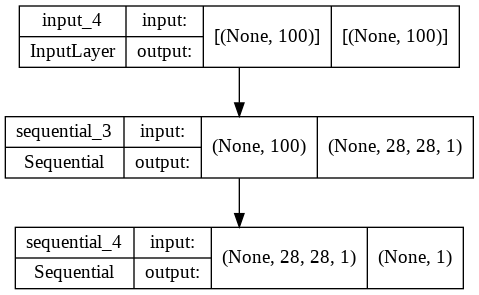

In [18]:
tf.keras.utils.plot_model(dcgan_model, show_shapes=True)

11501568/11490434 [==============================] - 0s 0us/step
epoch:0  d_loss:0.7307  g_loss:0.5240
epoch:1  d_loss:0.5490  g_loss:0.2458
epoch:2  d_loss:0.5500  g_loss:0.1612
epoch:3  d_loss:0.5321  g_loss:0.2030
epoch:4  d_loss:0.4753  g_loss:0.3169
epoch:5  d_loss:0.4781  g_loss:0.4614
epoch:6  d_loss:0.4973  g_loss:0.5507
epoch:7  d_loss:0.5554  g_loss:0.5421
epoch:8  d_loss:0.5385  g_loss:0.4653
epoch:9  d_loss:0.5754  g_loss:0.4151
epoch:10  d_loss:0.5639  g_loss:0.3753
epoch:11  d_loss:0.5291  g_loss:0.3604
epoch:12  d_loss:0.5285  g_loss:0.3897
epoch:13  d_loss:0.5193  g_loss:0.3986
epoch:14  d_loss:0.4959  g_loss:0.3921
epoch:15  d_loss:0.4711  g_loss:0.3822
epoch:16  d_loss:0.4515  g_loss:0.3594
epoch:17  d_loss:0.4342  g_loss:0.3290
epoch:18  d_loss:0.4253  g_loss:0.3537
epoch:19  d_loss:0.3992  g_loss:0.4323
epoch:20  d_loss:0.3606  g_loss:0.3487
epoch:21  d_loss:0.3458  g_loss:0.3063
epoch:22  d_loss:0.3295  g_loss:0.2351
epoch:23  d_loss:0.3717  g_loss:0.2605
epoch:24 

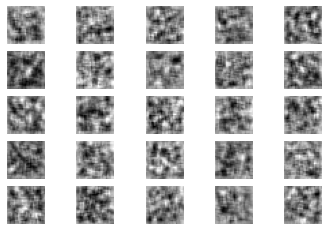

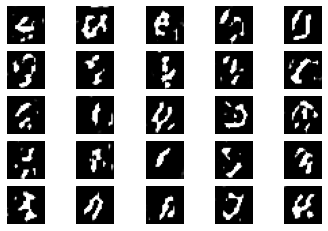

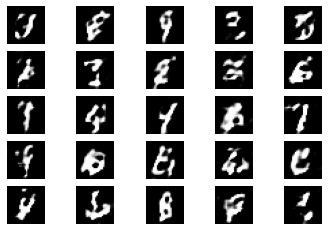

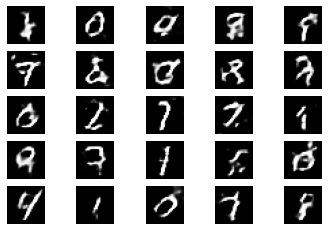

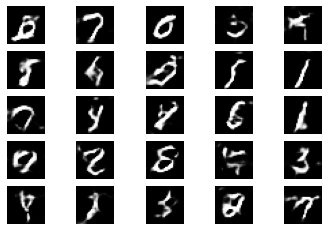

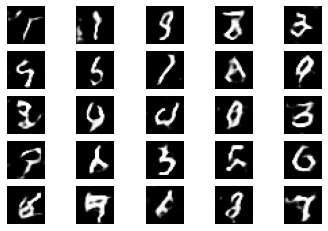

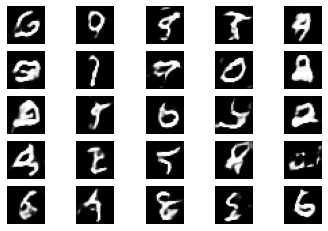

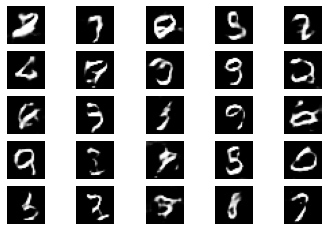

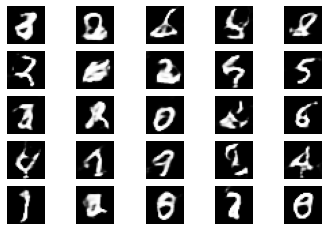

In [20]:
def dcgan_train(epoch, batch_size, saving_interval):
    (X_train, _), (_,_) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

    # -1 ~ 1
    X_train = (X_train - 127.5) / 127.5
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for i in range(epoch):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = d_model.train_on_batch(imgs, true)

        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = g_model.predict(noise)
        d_loss_fake = d_model.train_on_batch(gen_imgs, fake)

        d_loss = 0.5*np.add(d_loss_real, d_loss_fake)
        g_loss = dcgan_model.train_on_batch(noise, true)

        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        if i % saving_interval == 0:
            #r, c = 5, 5
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = g_model.predict(noise)

            # Rescale images 0 - 1
            gen_imgs = 0.5 * gen_imgs + 0.5

            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[j, k].axis('off')
                    count += 1

dcgan_train(4001, 32, 500)  #4000번 반복되고(+1을 해 주는 것에 주의), 배치 사이즈는 32,  200번 마다 결과가 저장되게 하였습니다.